# import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
#
matplotlib.rcParams['text.usetex'] = True
warnings.filterwarnings('ignore')

# input stress file

In [276]:
# path = './BmgData'
# fileNamee = ('FeNi.txt', 
#              'CoNiCr.txt', 
#              'CoNiCrFe.txt',
#              'CoCrFeMn.txt',
#              'Co5Cr2Fe40Mn27Ni26.txt')[1]

stress = np.loadtxt('%s/%s'%(path,fileNamee) )

# stress-strain curve

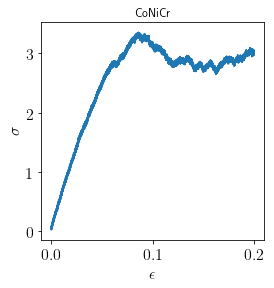

In [277]:
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\epsilon$',fontsize=16)
ax.set_ylabel(r'$\sigma$',fontsize=16)
ax.tick_params(labelsize=16)
ax.set_title(fileNamee[:-4])
#
ax.plot(stress[:,0],stress[:,1],'-')

#--- point corresponding to strain maps
ADD_POINTS = False
if ADD_POINTS:
    for itime in coord_atoms_broken:
        CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] )
        volume = np.linalg.det( CellVectorOrtho )
        virial = np.c_[coord_atoms_broken[itime]['c_mystress4']].astype(float).sum() / volume
        #--- strain
        dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
        l1=CellVector[ itime ][1,1]
        strain = 0.5*dx/l1
        ax.plot([2*strain],[virial*1e-4],'x',color='red')
#
plt.savefig(fileNamee[:-4]+'.png',dpi=75,bbox_inches='tight')
plt.show()

# Plastic Deformation
## Dump File

In [3]:
def GetCordsTimeStep(slist):
    slist.readline()
    itime = int( slist.readline().split()[0] )
    
    [slist.readline() for i in xrange(1)]
    nrows = int(slist.readline().split()[0])

    [slist.readline() for i in xrange(1)]
    
    CellVector = np.array([slist.readline().split() for i in xrange( 3 )])
    
    cols = slist.readline().split()[2:]
    
    return np.array([slist.readline().split() for i in xrange( nrows )]), CellVector, itime, cols
    
def GetCords( file_name ):
    slist = open( file_name )    
    coord_atoms_broken = {}
    CellVector = {}
    try:
        while True:
            sarr, cell_vector, itime, cols  = GetCordsTimeStep( slist ) #--- get coord
            #--- insert in a data frame
            coord_atoms_broken[ itime ] = pd.DataFrame( sarr, columns = cols )
            
            #--- cast id to 'int'
            coord_atoms_broken[ itime ]['id'] = map(int,coord_atoms_broken[ itime ]['id'].tolist())[:]

            #--- sort
            coord_atoms_broken[ itime ].sort_values( by = 'id', inplace = True )
            
            #--- reset index
            coord_atoms_broken[ itime ].reset_index( drop=True, inplace=True )
            
            CellVector[ itime ] = cell_vector
    except:
#        traceback.print_exc()
        pass

    
    return coord_atoms_broken, CellVector

def GetCellVector( CellVector ):
    CellVector[0] = np.c_[CellVector[0],['0.0','0.0','0.0']] #--- ref. state

    CellOrigin = {}
    cell_vector = {}
    
    for itime in CellVector:
        row0 = map( float, CellVector[ itime ][ 0 ] )
        l0 = row0[ 1 ] - row0[ 0 ] - row0[ 2 ]
        CellVector0 = np.array( [ l0, 0.0, 0.0 ] )
        dx = row0[ 2 ]
        
        row1 =  map( float, CellVector[ itime ][ 1 ] )
        l1 = row1[ 1 ] - row1[ 0 ]
        a1 = np.array( [ 0.0, l1, 0.0 ] )
        CellVector1 = CellVector0 * ( dx / l0 ) + a1
        
        row2 =  map( float, CellVector[ itime ][ 2 ] )
        l2 = row2[ 1 ] - row2[ 0 ]
        CellVector2 = np.array( [ 0.0, 0.0, l2 ] )
        
        CellOrigin[ itime ] = np.array( [ row0[ 0 ], row1[ 0 ], row2[ 0 ] ] )
        cell_vector[ itime ] = np.c_[ CellVector0, CellVector1, CellVector2 ] 

    return CellOrigin, cell_vector



# fileName = ('./BmgData/FeNi_glass.dump',
#             './BmgData/CoNiCr_glass.dump',
#             './BmgData/CoNiCrFe_glass.dump',
#             './BmgData/CoCrFeMn_glass.dump',
#             './BmgData/Co5Cr2Fe40Mn27Ni26_glass.dump')[1]#--- parse cords

#path = '/Users/Home/Desktop/Tmp/txt' 
fileName = '%s/virialStress.xyz'%path
coord_atoms_broken, cell_vector = GetCords( fileName ) #--- add xyz for broken bonds #--- check id!!1
CellOrigin, CellVector = GetCellVector( cell_vector )

## Compute Displacements


In [6]:
def ChangeBasis( coord_atoms_broken, CellVector, CellOrigin, **kwargs ):
############################################################
####### map atoms within a tilted box to an orthogonal one
############################################################

    DimensionlessCords = GetDimensionlessCords( CellVector, coord_atoms_broken, CellOrigin  ) #--- beta0, beta1, beta2

    #--- shift (beta0 + beta1 * dx / |b0| > 1) by - b0
    #--- [b0,b1]^{-1}*(x=|b0|,y)
    
    b2 = CellVector[:,2]
    b1 = CellVector[:,1]
    b0 = CellVector[:,0]
    norm_b0 = np.dot(b0,b0)**0.5
    shift0 = np.dot(b1, b0 / norm_b0 )
    #
    indices_shiftTrue = (DimensionlessCords['beta0']) + (DimensionlessCords['beta1'])*shift0/norm_b0 >= 1.0
    n = len( indices_shiftTrue )
    shift_matrix =  np.array(indices_shiftTrue).reshape((n,1)) * b0
    #
    xyz = coord_atoms_broken - shift_matrix
    #
    attr_list = ['x','y','z']
    values = xyz
    for keys in kwargs:
        attr_list += [ keys ]
        values = np.c_[values,kwargs[keys]]
                
    return pd.DataFrame( values, columns = attr_list )

def AddCopies( coord_atoms_broken, CellVector, **kwargs ):    
    #--- orignial cell
    XYZ_shifted = coord_atoms_broken
    xyz_original = XYZ_shifted.copy()
    #---
    attr_list = ['x','y','z']
    values = XYZ_shifted
    for keys in kwargs:
        attr_list += [ keys ]
        values = np.c_[values,kwargs[keys]]

    ID_TYPE_shifted = values[:,3:]
    id_type_original = ID_TYPE_shifted.copy()
    
    #--- cell copies
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            for k in [-1,0,1]:
    #            print i,j,k
                if i == j == k == 0:
                    continue
                total_shift = np.matmul( CellVector, np.array([i,j,k]) )
                #--- add shift
                xyz_shifted = xyz_original + total_shift
                #--- append
                XYZ_shifted = np.concatenate( ( XYZ_shifted, xyz_shifted ), axis = 0 )
                ID_TYPE_shifted = np.concatenate( ( ID_TYPE_shifted, id_type_original ), axis = 0 )
                                
    return pd.DataFrame(np.c_[XYZ_shifted,ID_TYPE_shifted],columns=attr_list)

def GetDimensionlessCords( CellVector, coord_atoms_broken, CellOrigin, **kwargs  ):
    xyz_centered = coord_atoms_broken - CellOrigin
    beta = np.matmul( np.linalg.inv(CellVector), xyz_centered.T).T
    
    attr_list = ['beta0', 'beta1', 'beta2']
    values = beta
    for keys in kwargs:
        attr_list += [ keys ]
        values = np.c_[values,kwargs[keys]]
        
    return pd.DataFrame( values, columns = attr_list  )

def shiftBeta( xyzDimensionless_j, diff, key = 'beta0' ):
    indices = diff[key] > 0.5
    beta0_j = xyzDimensionless_j[key] - 1.0 * indices

    indices = diff[key] < -0.5
    beta0_j += 1.0 * indices
    
    return beta0_j

def GetXYZ( CellVector, CellOrigin, DimensionlessCords, attr_list = ['x','y','z'], **kwargs ):
    XYZ_centered = np.matmul( CellVector, DimensionlessCords.T ).T #--- xyz in reference state
    XYZ = XYZ_centered + CellOrigin
    
    
    values = XYZ
    for keys in kwargs:
        attr_list += [ keys ]
        values = np.c_[values,kwargs[keys]]
        
    return pd.DataFrame( values, columns = attr_list)

def EstimateUnwrappedCord( coord_atoms_broken_i, coord_atoms_broken_j,
                           CellVector_i, CellVector_j,
                           CellOrigin_i, CellOrigin_j):
#--- dimensionless cords
    xyzDimensionless_i = GetDimensionlessCords( CellVector_i, coord_atoms_broken_i, CellOrigin_i )
    xyzDimensionless_j = GetDimensionlessCords( CellVector_j, coord_atoms_broken_j, CellOrigin_j )

    #--- shift to get unwrapped cords
    diff = xyzDimensionless_j[['beta0','beta1','beta2']] - xyzDimensionless_i[['beta0','beta1','beta2']]

    #--- new dimensionless cords
    beta0_j = shiftBeta( xyzDimensionless_j, diff, key = 'beta0' )
    beta1_j = shiftBeta( xyzDimensionless_j, diff, key = 'beta1' )
    beta2_j = shiftBeta( xyzDimensionless_j, diff, key = 'beta2' )

    #--- unwrapped cords at deformed state
    rj_unwrpd = GetXYZ( CellVector_j, CellOrigin_j, np.c_[beta0_j,beta1_j,beta2_j] )

    return rj_unwrpd




#--- do mapping & add copies
coord = {}
#ITIME = 2100
for itime in coord_atoms_broken:
    #--- map atoms in the ref. state to an undeformed box
    df = coord_atoms_broken[ itime ][['id','type','x','y','z']]
    xyz = np.c_[df[['x','y','z']].astype('float')]
    xyz_mapped = ChangeBasis( xyz, CellVector[ itime ], CellOrigin[ itime ] )

    #--- append
    tmp = pd.DataFrame(np.c_[df, xyz_mapped],columns=['id','type','x','y','z','xm','ym','zm'])
        
    #--- add copies
    df = tmp
    xyz = np.c_[df[['x','y','z']].astype('float')]
    xyz_copy = AddCopies( xyz, CellVector[ itime ],
                          id=df['id'],
                          type = df['type']
                        )
    xyz_m = np.c_[df[['xm','ym','zm']].astype('float')]
    xyz_m_copy = AddCopies( xyz_m, CellVector[ itime ],
                          id=df['id'],
                          type = df['type']
                        )
    coord[itime] = pd.DataFrame(np.c_[xyz_copy[['id','type','x','y','z']],xyz_m_copy[['x','y','z']]],columns=['id','type','x','y','z','xm','ym','zm'])

#---
#--- compute displacements
#---
REF = ('initial', 'previous')[0] #--- displ. with respect to an initial state or previous state

times = coord_atoms_broken.keys()
times.sort()
for time_i, time_j in zip(times[:-1], times[1:]):   
    if REF == 'initial':
        time_i = 0
    print time_i, time_j
    #--- estimate unwrapped coordinates (deformed state)
    # r^{wrpd}_i, r^{wrpd}_j, r^{unwrpd}_j
    xyz_i = np.c_[coord[time_i][['x','y','z']]].astype('float')
    xyz_j = np.c_[coord[time_j][['x','y','z']]].astype('float')
    rj_unwrpd = EstimateUnwrappedCord( xyz_i, xyz_j,
                                       CellVector[time_i], CellVector[time_j],
                                       CellOrigin[time_i], CellOrigin[time_j] )    
    #--- displacement: r^{unwrpd}_j - r^{wrpd}_i
    disp = rj_unwrpd[['x','y','z']] - xyz_i
        
    #--- append (xm,ym,zm) denoting mapped coordinates
    df = coord[ time_j ]
    coord[ time_j ] = pd.DataFrame(np.c_[df, disp],columns=['id','type','x','y','z','xm','ym','zm','ux','uy','uz'])


    
    

0 10000


### Print

In [8]:
def GetOrthogonalBasis( CellVector ): 
    a0 = CellVector[:,0]
    l0 = np.dot(a0,a0)**0.5
    n0 = a0 / l0 
    #
    a1 = CellVector[:,1]
    a1_perp = a1 - np.dot( a1, n0 ) * n0
    l1 = np.dot( a1_perp, a1_perp) ** 0.5
    #
    a2 = CellVector[:,2]
    l2 = np.dot(a2,a2)**0.5
    
    return np.c_[a0, a1_perp, a2], [l0, l1, l2]

def GetPoints( CellOrigin, CellVector, xyz, ev = 0.2, output_attr = ['x','y','z'],**kwargs ):
    
    #--- tensor associated with dilation
    strainTensor = np.array([[ev/3.0,0,0],
                            [0,ev/3.0,0],
                            [0,0,ev/3.0]])
    #
    identityMat = np.array([[1,0,0],[0,1,0],[0,0,1]])
    #
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )

    #--- extend diagonal
    rvect = -np.matmul( CellVectorOrtho, np.array([0.5,0.5,0.5]))
    CellOrigin_expanded = CellOrigin + np.matmul(strainTensor,rvect)

    #--- extend basis vectors
    CellVector_expanded = np.matmul( identityMat + strainTensor, CellVectorOrtho )

    #--- (beta0,beta1,beta2) associated with original atoms and their images 
    #--- with reference to the expanded box 
    DimensionlessCords = GetDimensionlessCords( CellVector_expanded, 
                                                xyz,
                                                CellOrigin_expanded,
                                                **kwargs )
    #--- filter: only inside the expanded box 
    index0 = np.all([DimensionlessCords['beta0'] >= 0.0, DimensionlessCords['beta0'] < 1.0], axis=0 )
    index1 = np.all([DimensionlessCords['beta1'] >= 0.0, DimensionlessCords['beta1'] < 1.0], axis=0 )
    index2 = np.all([DimensionlessCords['beta2'] >= 0.0, DimensionlessCords['beta2'] < 1.0], axis=0 )
    bete_inside = DimensionlessCords[np.all([index0,index1,index2],axis=0)]

    #--- xyz coordinates
    kwargss = {}
    for keys in kwargs:
        kwargss[ keys ] = bete_inside[ keys ]        
    xyz_inside = GetXYZ( CellVector_expanded, CellOrigin_expanded, 
                         np.c_[bete_inside[['beta0','beta1','beta2']]],
                         output_attr,
                         **kwargss )
    
    return xyz_inside

def PrintOvito( cordc, sfile, footer, attr_list=['x','y','z'] ):
    smat = cordc[attr_list]
    np.savetxt(sfile,[len(smat)],fmt='%s', footer='%s, %s'%(footer,str(attr_list)))
    np.savetxt(sfile,smat,fmt='%s')
    sfile.close()



#--- print 
file_name = 'displ.xyz'
try:
    os.system('rm %s'%file_name)
except:
    pass

times = coord.keys()
times.sort()
for time_i, time_j in zip(times[:-1], times[1:]):   
    if REF == 'initial':
        time_i = 0
    #--- get a chunck of full copies
    df_i = coord[ time_i ]
    df_j = coord[ time_j ]

    df_chunk =  GetPoints( CellOrigin[ time_i ], 
                               CellVector[ time_i ],
                               np.c_[df_i[['xm','ym','zm']]].astype('float'), #--- give mapped coordinates
                               ev = 0.3,
                               output_attr = ['xm','ym','zm'],
                               id = df_i['id'],
                               type = df_i['type'],
                               x = df_i['x'],
                               y = df_i['y'],
                               z = df_i['z'],
                               ux = df_j['ux'],
                               uy = df_j['uy'],
                               uz = df_j['uz'],
                             )
    

    PrintOvito( df_chunk, 
                open(file_name,'a'), 
                footer = 'ITIME=%s'%time_j,
                attr_list=['id','type','xm','ym','zm','ux','uy','uz'] )



## Gradients

### Interpolate Displacements
#### cubic grid

In [9]:
def GetCubicGrid( CellOrigin, CellVector, dmean, margin  ):

    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )
    
    volume = np.linalg.det( CellVectorOrtho )


    [nx, ny, nz] = map( int, (np.array(VectorNorm)+2*margin) / dmean )
    if nx%2 == 0:
        nx += 1
    if ny%2 == 0:
        ny += 1
    if nz%2 == 0:
        nz += 1
    
    x = np.linspace( CellOrigin[0] - margin, CellOrigin[0] + VectorNorm[ 0 ] + margin, nx,endpoint=False)
    y = np.linspace( CellOrigin[1] - margin, CellOrigin[1] + VectorNorm[ 1 ] + margin, ny,endpoint=False)
    z = np.linspace( CellOrigin[2] - margin, CellOrigin[2] + VectorNorm[ 2 ] + margin, nz,endpoint=False)

    return (x, y, z), np.meshgrid(x, y,z)



#--- mean dist between atoms 
natoms = len( coord_atoms_broken[ 0 ] ) 
CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ 0 ] )
volume = np.linalg.det( CellVectorOrtho )
dmean = ( volume / natoms ) ** (1.0/3.0) 

#--- grid tiling mapped box with original size
#--- values are interpolated onto this grid
(xlin, ylin, zlin), (xv, yv, zv) = GetCubicGrid( CellOrigin[ 0 ], 
                                                 CellVector[ 0 ], 
                                                 dmean,
                                                 margin = 0.0 * dmean )
xi = np.array(zip(xv.flatten(), yv.flatten(), zv.flatten()))


#### center box + margin

In [10]:
df_intrp = {}
times = coord.keys()
times.sort()
for time_i, time_j in zip(times[:-1], times[1:]):   
    if REF == 'initial':
        time_i = 0
    #--- get a chunck of full copies
    df_i = coord[ time_i ]
    df_j = coord[ time_j ]
    
    #--- get points from which values are interpolated
    pointsValues =  GetPoints( CellOrigin[ time_i ], 
                               CellVector[ time_i ],
                               np.c_[df_i[['xm','ym','zm']]].astype('float'), #--- give mapped coordinates
                               ev = 0.3,
                               output_attr = ['xm','ym','zm'],
                               id = df_i['id'],
                               type = df_i['type'],
                               x = df_i['x'],
                               y = df_i['y'],
                               z = df_i['z'],
                               ux = df_j['ux'],
                               uy = df_j['uy'],
                               uz = df_j['uz'],
                             )
        
    #--- interpolate
    points = pointsValues[['xm','ym','zm']]
    values = pointsValues[['ux','uy','uz']]
    grid_z = scp_int.griddata(points, values, xi, method='linear')
    assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'
    
    #--- store in dataframe
    df_intrp[ time_j ] = pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','ux','uy','uz'])


#### Print

In [14]:
file_name = 'intrp.xyz'
try:
    os.system('rm %s'%file_name)
except:
    pass

for itime in df_intrp:
    PrintOvito( df_intrp[ itime ], 
                    open( file_name,'a'), 
                    footer = 'ITIME=%s'%itime,
                    attr_list=['x','y','z','ux','uy','uz'] )


### Strain tensor

In [11]:
def GetStrain( value, (xlin,ylin,zlin), (xv,yv,zv)):
    #--- reshape matrix
    nx,ny,nz = len(xlin), len(ylin),len(zlin) 
    ux = np.c_[value['ux']].reshape((ny,nx,nz))
    uy = np.c_[value['uy']].reshape((ny,nx,nz))
    uz = np.c_[value['uz']].reshape((ny,nx,nz))

    #--- gradient
    ux_x = np.gradient(ux,xlin,axis=1)
    ux_y = np.gradient(ux,ylin,axis=0)
    ux_z = np.gradient(ux,zlin,axis=2)

    uy_x = np.gradient(uy,xlin,axis=1)
    uy_y = np.gradient(uy,ylin,axis=0)
    uy_z = np.gradient(uy,zlin,axis=2)

    uz_x = np.gradient(uz,xlin,axis=1)
    uz_y = np.gradient(uz,ylin,axis=0)
    uz_z = np.gradient(uz,zlin,axis=2)

    #--- strain
    exx = ux_x
    exy = 0.5 * ( ux_y + uy_x )
    exz = 0.5 * ( ux_z + uz_x )

    eyx = exy
    eyy = uy_y
    eyz = 0.5 * ( uy_z + uz_y )

    ezx = exz
    ezy = eyz
    ezz = uz_z
    
    #--- subtract mean
    exx -= np.mean(exx)
    exy -= np.mean(exy)
    exz -= np.mean(exz)

    eyx -= np.mean(eyx)
    eyy -= np.mean(eyy)
    eyz -= np.mean(eyz)

    ezx -= np.mean(ezx)
    ezy -= np.mean(ezy)
    ezz -= np.mean(ezz)
    
    return pd.DataFrame(np.c_[xv.flatten(),yv.flatten(),zv.flatten(),
                 exx.flatten(), eyy.flatten(), ezz.flatten(), 
                 exy.flatten(), eyz.flatten(), ezx.flatten()], 
                 columns = ['x','y','z','exx','eyy','ezz','exy','eyz','ezx'])

Strain = {}
for itime in df_intrp:
    Strain[itime] = GetStrain(df_intrp[ itime ], (xlin,ylin,zlin), (xv,yv,zv))


#### imshow

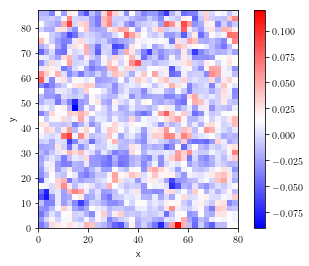

In [14]:
def FilterMatrix( CellVector, CellOrigin,
                  (xlin, ylin, zlin),
                  (xv, yv, zv ),
                   value
                ):
    #--- xlims of the original box
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )
    margin = 0.0    
    (xlo,xhi)=( CellOrigin[0] - margin, CellOrigin[0] + VectorNorm[ 0 ] + margin)
    (ylo,yhi)=( CellOrigin[1] - margin, CellOrigin[1] + VectorNorm[ 1 ] + margin)
    (zlo,zhi)=(CellOrigin[2] - margin, CellOrigin[2] + VectorNorm[ 2 ] + margin )

    #--- grid dimension tiling the original box
    indices = np.all([xlin>=xlo, xlin<xhi],axis=0)
    nx = xlin[indices].shape[0]
    indices = np.all([ylin>=ylo, ylin<yhi],axis=0)
    ny = ylin[indices].shape[0]
    indices = np.all([zlin>=zlo, zlin<zhi],axis=0)
    nz = zlin[indices].shape[0]

    #--- filter matrices
    indices = np.all([xv>=xlo,xv<xhi, yv>=ylo,yv<yhi, zv>=zlo,zv<zhi ],axis=0)
    vf_flatten = value[indices] #--- filter extended grid
    assert vf_flatten.shape[0] == nx*ny*nz, '%s != %s'%(vf_flatten.shape[0], nx*ny*nz)
    vf = vf_flatten.reshape((ny,nx,nz))
    return vf

def CenterMatrix(a):
    ( mgrid, ngrid ) = a.shape
    return np.array([[ a[i,j] for j in xrange(-(ngrid/2),ngrid/2+ngrid%2)] 
                              for i in xrange(-(mgrid/2),mgrid/2+mgrid%2)])

def PltBitmap( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
             ):
        
    val = value.copy()
    #--- z-score
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #--- plot
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    pos = plt.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),origin='lower')# ,vmin=-.6, vmax=.6)
#    plt.xlim(center[0]-(ngrid/2)*frac,center[0]+(ngrid/2)*frac)
#    plt.ylim(center[1]-(mgrid/2)*frac,center[1]+(mgrid/2)*frac)
#    plt.xlim(xlim[0]*frac,xlim[1]*frac)
#    plt.ylim(ylim[0]*frac,ylim[1]*frac)
    plt.colorbar( pos, fraction = 0.04)
    plt.savefig('cxy.png',dpi=75,bbox_inches='tight')
    plt.show()


    

itime = np.max(Strain.keys())
#--- reshape value
nx,ny,nz = len(xlin), len(ylin),len(zlin) 
value = np.c_[Strain[itime]['exy']].reshape(((ny,nx,nz)))
#--- filter value
# value = FilterMatrix( CellVector[0], CellOrigin[0],
#                   (xlin, ylin, zlin),
#                   (xv, yv, zv ),
#                    value )
#print value.shape
#print vf.shape

CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] ) #--- box length
#--- xy plane
val = value[:,:,-1].copy()
#print val.shape

PltBitmap(val, 
          xlabel = 'x', ylabel = 'y',
          xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
          zscore = None,
          frac = 1.0, #--- plot a patch
        )

In [13]:
Strain.keys()

[10000]

#### Print

In [286]:
file_name = 'strain.xyz'
try:
    os.system('rm %s'%file_name)
except:
    pass
    
times = Strain.keys()
times.sort()
for itime in times:
    #--- bulk strain
    dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
    l1=CellVector[ itime ][1,1]
    ebulk = 0.5*dx/l1

    
    PrintOvito( Strain[ itime ], 
                    open( file_name,'a'), 
                    footer = 'epsilon=%2.1e'%(2*ebulk),
                    attr_list=['x','y','z','exx','eyy','ezz','exy','eyz','ezx'] )
    

#### Auto-Correlations

In [287]:
def GetAutoCorrelation( val ):
    value  = val.copy()
    value -= np.mean( value )
    value /= np.std( value )

    ( nx, ny, nz ) =  value.shape
    n = nx * ny * nz
    vq = np.fft.fftn(value) #, axes=(0,1,2))
    vq_sq = np.abs(vq)**2

    v_real = np.fft.ifftn( vq_sq) / n #,  axes=(0,1,2) )
    return v_real


Crltn = {}
for itime in df_intrp:
    #
    (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
    #
    value = np.c_[Strain[itime]['exy']].reshape(((ny,nx,nz)))
    #
    #--- filter value
#     value = FilterMatrix( CellVector[0], CellOrigin[0],
#                   (xlin, ylin, zlin),
#                   (xv, yv, zv ),
#                    value )

    Crltn[ itime ] = GetAutoCorrelation( value )


#### Print

itime= 500000


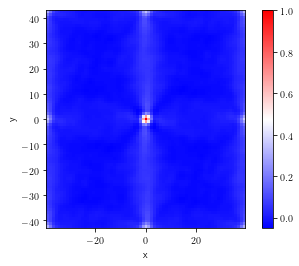

itime= 1000000


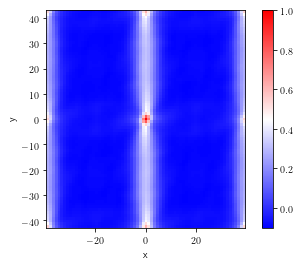

itime= 2000000


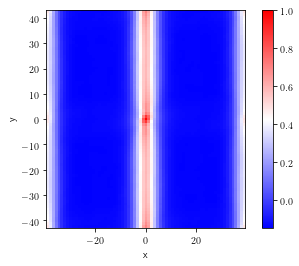

itime= 1500000


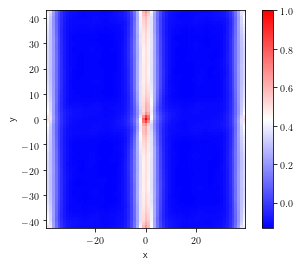

In [291]:

def PltCrltn( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              fileName = 'cxy.png',
              dpi=75,
            ):
        
    val = value.copy()
    #--- zscore
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    pos = plt.imshow((CenterMatrix( val ).real),cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1])) #,vmin=-.01, vmax=.01)
    plt.xlim(xlim[0]*frac,xlim[1]*frac)
    plt.ylim(ylim[0]*frac,ylim[1]*frac)

    plt.colorbar( pos, fraction = 0.04)
    plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
    plt.show()


for itime in Crltn:
    print 'itime=',itime
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] ) #--- box length
    #    
    crltn = Crltn[ itime ]
    #--- xy plane
    val = crltn[:,:,0].copy()
    PltCrltn( val, 
              xlabel = 'x', ylabel = 'y',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              frac = 1, #--- plot a patch
              zscore = False,
              fileName = 'cxy.%s.png'%itime,
              dpi = 60
            )
    # #--- zx plane
    # val = crltn[0,:,:].copy()
    # PltCrltn( val, 
    #           xlabel = 'z', ylabel = 'x',
    #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[0]*np.array([-0.5,0.5]),
    #           frac = 1.0, #--- plot a patch
    #           zscore = False,
    #         )
    # #--- zy plane
    # val = crltn[:,0,:].copy()
    # PltCrltn( val, 
    #           xlabel = 'z', ylabel = 'y',
    #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
    #           frac = 1.0, #--- plot a patch
    #           zscore = False,
    #         )



#### Crltn Length

itime= 500000


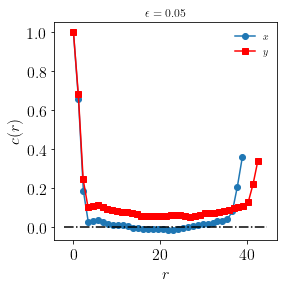

itime= 1000000


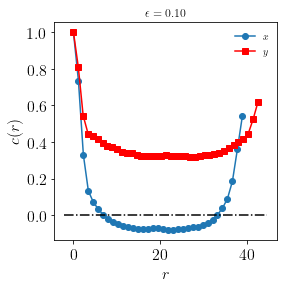

itime= 2000000


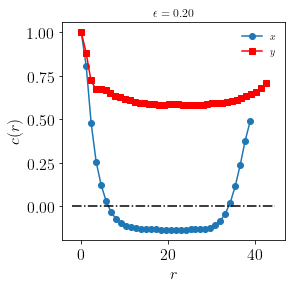

itime= 1500000


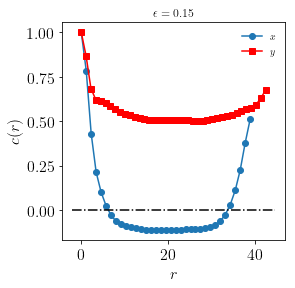

In [289]:
def Get_rc( xdata, ydata, cTOL ):
    try:
        xc1 = xdata[np.abs(ydata)<cTOL][0] 
    except:
        xc1 = np.nan
    try:    
        xc2 = xdata[ydata<0.0][0] #--- correlation length
    except:
        xc2 = np.nan
    try:
        xc = np.array([xc1,xc2])
        xc = xc[~np.isnan(xc)].min()
    except:
        xc = np.nan
    return xc

def PltCrltnFunc( crltn, 
                 (xv,yv),
                 cTOL = 1.0e-2,
                 PLOT = True,
                 fileName='cxy.png',
                 title = '',
                 dpi = 60,
                ):
    if PLOT:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        xstr = r'$r$'
        ystr = r'$c(r)$'
        ax.set_xlabel(xstr,fontsize=16)
        ax.set_ylabel(ystr,fontsize=16)
        ax.tick_params(labelsize=16)
    #
    val = crltn[:,:,0].copy() #--- only xy plane
    (m,n)=val.shape
    #--- along x 
    xv2 = xv[:,:,0].copy()
    dx = xv2[0,1] - xv2[0,0]
    #
    xdata = np.arange(0,(n/2+n%2)) * dx
    ydata = val[row,0:(n/2+n%2)]
    #
    xc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.plot( xdata, ydata,'-o',label=r'$x$')       
    #--- along y 
    yv2 = yv[:,:,0].copy()
    dy = yv2[1,0] - yv2[0,0]
    #
    xdata = np.arange(0,(m/2+m%2)) * dy
    ydata = val[0:(m/2+m%2),0]
    #
    yc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.plot( xdata, ydata,'-s', color = 'red',label=r'$y$')
    #--- plot
    if PLOT:
        ax.legend(frameon=False)
        ax.set_title( title )
        #ax.set_yscale('log')
        #
        ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='black')
#        ax.plot((rc,rc),ax.axis()[2:],'-.r')
        #
        #
        plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
        plt.show()
    #
    return (xc, yc)
    
    

for itime in Crltn:
    print 'itime=',itime
    #--- bulk strain
    dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
    l1=CellVector[ itime ][1,1]
    ebulk = 0.5*dx/l1
    #---
    PltCrltnFunc( Crltn[ itime ], 
                 (xv,yv),
                 fileName = 'cr.%s.png'%itime,
                 title = r'$\epsilon=%3.2f$'%(2*ebulk),
                 cTOL = 8.0e-2,
                 dpi = 60,
                )

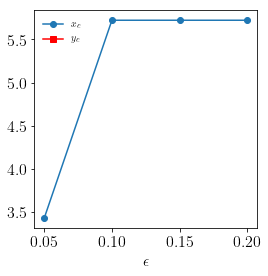

In [292]:
#--- extract length
ebulk = []
Xc = []
Yc = []
keys = Crltn.keys()
keys.sort()
for itime in keys:
    #--- bulk strain
    dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
    l1=CellVector[ itime ][1,1]
    ebulk += [0.5*dx/l1]
    
    xc, yc = PltCrltnFunc( Crltn[ itime ], 
                          (xv,yv),
                          cTOL = 4e-2,
                          PLOT = None,
                         )
    Xc += [xc]
    Yc += [yc]

#--- plot
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
xstr = r'$\epsilon$'
ystr = r'$r_c$'
ax.set_xlabel(xstr,fontsize=16)
#ax.set_ylabel(ystr,fontsize=16)
ax.tick_params(labelsize=16)
#
ax.plot( 2*np.array(ebulk), Xc,'-o', color='C0', label = r'$x_c$')
ax.plot( 2*np.array(ebulk), Yc,'-s', color='red', label = r'$y_c$')
ax.legend(frameon=False)
plt.savefig('rc.png',dpi=75,bbox_inches='tight')
plt.show()
